# Load in Dataset and Tools

So, to get started we're going to pull the pkl file that I saved our last dataset to - the one that we cleaned up and truncated down. It's still a pretty hefty 21K rows, so we've still got plenty to play with this time.

We're basically going to make use of the same tools this time, except we're also going to bring in statsmodels to run quick OLS tests on variations of our final model. Let's get started.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 3266-66A9

 Directory of C:\Users\mulli\Data-Science-Local\M01-Project

06/15/2019  10:48 PM    <DIR>          .
06/15/2019  10:48 PM    <DIR>          ..
06/15/2019  08:13 PM    <DIR>          .ipynb_checkpoints
06/15/2019  10:48 PM            58,388 Data Cleaning.ipynb
06/15/2019  08:13 PM         3,707,090 df_truncated.pkl
06/15/2019  08:13 PM           207,667 EDA.ipynb
06/15/2019  08:13 PM           110,623 EDA2.ipynb
06/15/2019  08:13 PM         2,475,934 kc_house_data.csv
06/15/2019  08:13 PM         2,536,820 kc_house_data_orig.csv
               6 File(s)      9,096,522 bytes
               3 Dir(s)  203,447,803,904 bytes free


In [3]:
df = pd.read_pickle('df_truncated.pkl')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Check for Multicolinearity 

Let's focus for right now on making this dataset more easy to manage - trying to track relationships between 20+ variables is not the easiest task to get started with. We're going to do this by looking at a Seaborn heatmap of the dataframe's correlation matrix.

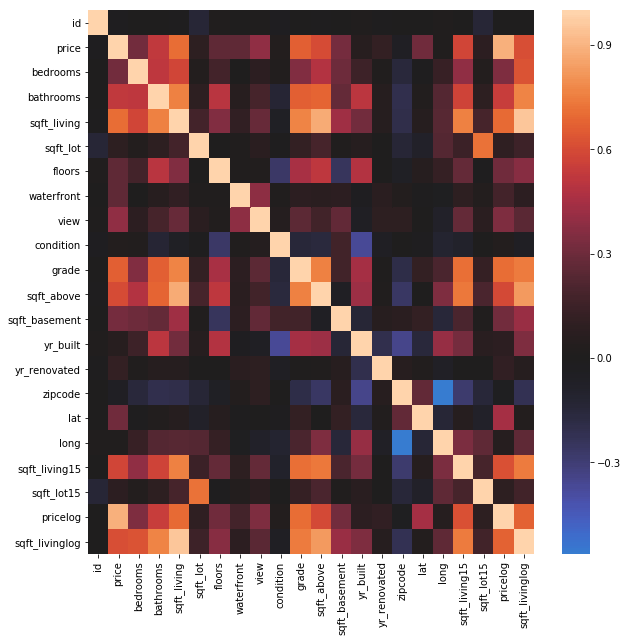

In [27]:
plt.figure(figsize=[10,10])
sns.heatmap(df.corr(), center = 0)

From here we can see a few things:

* `sqft_living` and `sqft_living15` share a pretty close relationship. Remember that the '15' columns are derivatives of their regular counterparts. We can model one and not the other.
*  `sqft_living` is closely related to `sqft_above`, so we should be sure to model one and not the other.
* There are several variables with almost no interaction: `id`, which is the arbitrary property ID, so that's not a surprise; `yr_renovated` is another with almost no interaction
* In all, it looks like there's not a high risk of multicolinearity, with the exception of running our model with either of the 2015 modified columns.

So, that being said, let's move on.

# Is 'Price' Normally Distributed?

Since we're going to be focused on what's going to work well in predicting price, we want to see how close it is to a standard distribution as-is, and see if maybe we want to normalize it from there. We're just going to take a quick look at a histogram of price and its KDE.

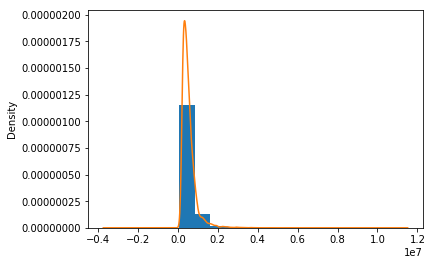

In [4]:
plt.hist(df['price'], density = True)
df['price'].plot.kde()

This is not looking like normally distributed data, so we're going to transform it. Simplest option is always a log transform, as I don't have to load in any extra formulas.

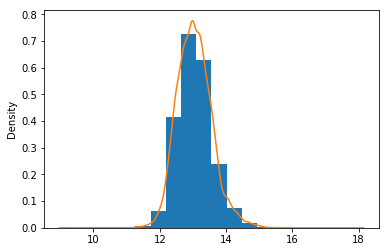

In [6]:
df['pricelog'] = np.log(df['price'])
plt.hist(df['pricelog'], density = True)
df['pricelog'].plot.kde()

# Now that we've got Price normally distributed, what correlates with it?
 
 Let's take a look at what works with our new `pricelog` variable.

In [9]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog
id,1.000000,-0.018183,0.003041,0.003900,-0.013662,-0.132794,0.019030,-0.003792,0.011086,-0.022093,...,-0.012341,-0.005470,0.021251,-0.010933,-0.007295,-0.004350,0.021011,-0.004051,-0.138706,-0.006103
price,-0.018183,1.000000,0.310197,0.526757,0.702790,0.088384,0.255378,0.266549,0.393069,0.036172,...,0.605928,0.322578,0.053578,0.118673,-0.052655,0.305339,0.021363,0.584449,0.082992,0.891452
bedrooms,0.003041,0.310197,1.000000,0.515292,0.579209,0.033277,0.178470,-0.002238,0.078697,0.024718,...,0.480913,0.298377,0.155592,0.017884,-0.153605,-0.011213,0.131210,0.393725,0.031209,0.344334
bathrooms,0.003900,0.526757,0.515292,1.000000,0.755893,0.089415,0.503405,0.064271,0.186356,-0.127350,...,0.687643,0.279170,0.507556,0.048092,-0.204253,0.023447,0.224609,0.569712,0.088926,0.551478
sqft_living,-0.013662,0.702790,0.579209,0.755893,1.000000,0.175048,0.353515,0.105542,0.281639,-0.060849,...,0.877094,0.430710,0.318392,0.051496,-0.200248,0.051286,0.241386,0.756825,0.185463,0.695856
sqft_lot,-0.132794,0.088384,0.033277,0.089415,0.175048,1.000000,-0.006461,0.021831,0.072508,-0.008690,...,0.184971,0.016874,0.052732,0.005127,-0.130296,-0.086335,0.231066,0.145821,0.722416,0.099299
floors,0.019030,0.255378,0.178470,0.503405,0.353515,-0.006461,1.000000,0.020827,0.027113,-0.264980,...,0.523214,-0.242274,0.489723,0.003511,-0.058612,0.048510,0.125942,0.278872,-0.009957,0.309650
waterfront,-0.003792,0.266549,-0.002238,0.064271,0.105542,0.021831,0.020827,1.000000,0.386162,0.016854,...,0.072314,0.083683,-0.024953,0.073715,0.029433,-0.012347,-0.038160,0.084777,0.030782,0.172735
view,0.011086,0.393069,0.078697,0.186356,0.281639,0.072508,0.027113,0.386162,1.000000,0.045265,...,0.165867,0.271289,-0.055311,0.092124,0.086199,0.006707,-0.078357,0.278246,0.071907,0.344498
condition,-0.022093,0.036172,0.024718,-0.127350,-0.060849,-0.008690,-0.264980,0.016854,0.045265,1.000000,...,-0.159672,0.168836,-0.362460,-0.056253,0.003710,-0.015512,-0.106781,-0.092819,-0.003816,0.038458


`sqft_living` looks like it has a very strong relationship with `pricelog` right now. Let's take a look at it in a little more detail.

In [10]:
df['sqft_living'].describe()

count    21054.000000
mean      2082.089864
std        920.578886
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

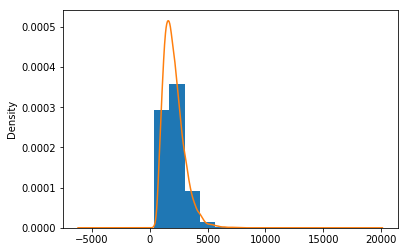

In [13]:
plt.hist(df['sqft_living'], density = True)
df['sqft_living'].plot.kde()

Attempting another log transform on `sqft_living` to see if we can get a more normal distribution out of it as well.

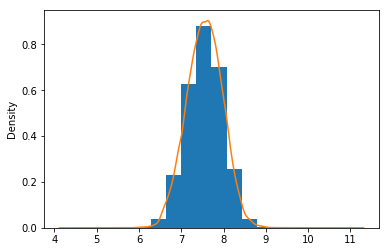

In [14]:
df['sqft_livinglog'] = np.log(df['sqft_living'])
plt.hist(df['sqft_livinglog'], density = True)
df['sqft_livinglog'].plot.kde()

# What Next?

### Geographer's Choice:

Speaking from my background as an educated geographer, I can already tell that location is going to be important in our determination. We're talking about property values, which have been historically tied to cultural values (e.g. which neighborhoods are hot; which neighborhoods are being subsidized; which neighborhoods have been ghettoized; etc) and geographic features.

We need to take a look at our latitude and longitude fields, but first, let's make sure that these sales accurately represent an urban system.

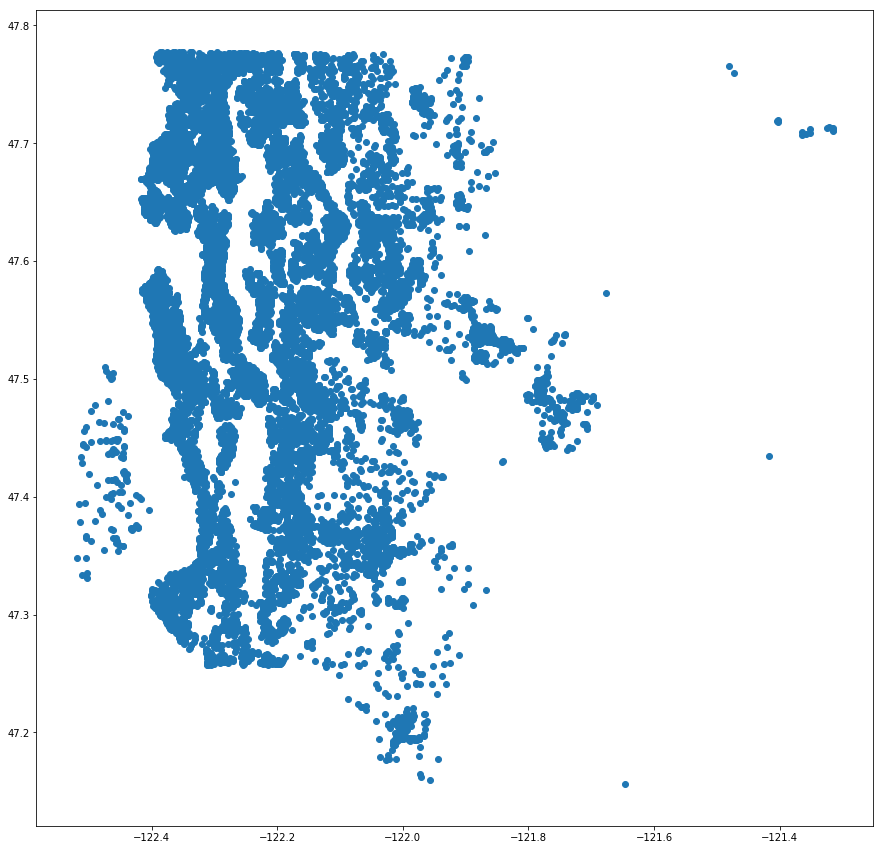

In [22]:
fig = plt.figure(figsize=[15,15])
plt.scatter(df['long'],df['lat'])

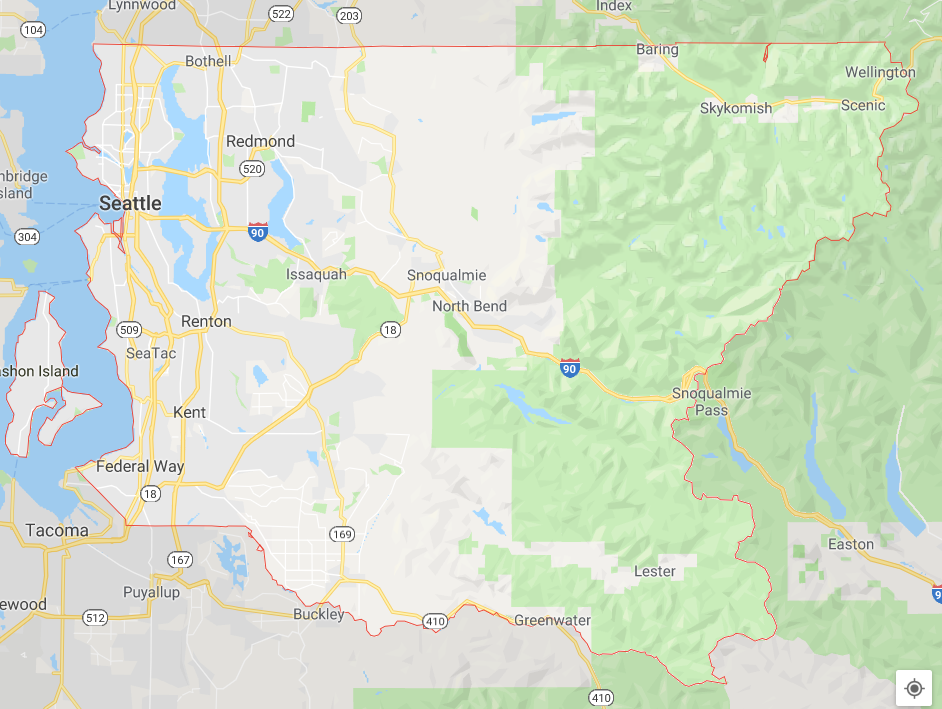

From here we can see there's a very clear overlap:  we can see the outline of multiple water features, but also swaths of land that are left 'empty.' These could represent city zoning laws - that is to say, they could be industrial parks or industrial-commercial parks - but at this time, we don't have enough information to know. What we do know is that very plainly, houses are 'clustered' together.

## Should we transform this data?

Transforming the long/lat data will only rob it of its meaning to the context. We can and should use our location data, but there's no reason to transform it when doing so will make it meaningless.

## Getting our bearings again.

From here, we should check out `df.corr` and see what we can pick out next.

In [155]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog,sqft_livinglog,grg,grg_dcenter
id,1.000000,-0.018183,0.003041,0.003900,-0.013662,-0.132794,0.019030,-0.003792,0.011086,-0.022093,...,-0.010933,-0.007295,-0.004350,0.021011,-0.004051,-0.138706,-0.006103,-0.003201,0.011282,-0.008587
price,-0.018183,1.000000,0.310197,0.526757,0.702790,0.088384,0.255378,0.266549,0.393069,0.036172,...,0.118673,-0.052655,0.305339,0.021363,0.584449,0.082992,0.891452,0.612008,-0.264042,-0.278656
bedrooms,0.003041,0.310197,1.000000,0.515292,0.579209,0.033277,0.178470,-0.002238,0.078697,0.024718,...,0.017884,-0.153605,-0.011213,0.131210,0.393725,0.031209,0.344334,0.622572,0.056195,-0.028155
bathrooms,0.003900,0.526757,0.515292,1.000000,0.755893,0.089415,0.503405,0.064271,0.186356,-0.127350,...,0.048092,-0.204253,0.023447,0.224609,0.569712,0.088926,0.551478,0.762083,0.058253,-0.042207
sqft_living,-0.013662,0.702790,0.579209,0.755893,1.000000,0.175048,0.353515,0.105542,0.281639,-0.060849,...,0.051496,-0.200248,0.051286,0.241386,0.756825,0.185463,0.695856,0.954407,0.039433,-0.093343
sqft_lot,-0.132794,0.088384,0.033277,0.089415,0.175048,1.000000,-0.006461,0.021831,0.072508,-0.008690,...,0.005127,-0.130296,-0.086335,0.231066,0.145821,0.722416,0.099299,0.151749,0.158117,0.101428
floors,0.019030,0.255378,0.178470,0.503405,0.353515,-0.006461,1.000000,0.020827,0.027113,-0.264980,...,0.003511,-0.058612,0.048510,0.125942,0.278872,-0.009957,0.309650,0.367439,0.001153,-0.005884
waterfront,-0.003792,0.266549,-0.002238,0.064271,0.105542,0.021831,0.020827,1.000000,0.386162,0.016854,...,0.073715,0.029433,-0.012347,-0.038160,0.084777,0.030782,0.172735,0.079710,-0.002401,-0.049141
view,0.011086,0.393069,0.078697,0.186356,0.281639,0.072508,0.027113,0.386162,1.000000,0.045265,...,0.092124,0.086199,0.006707,-0.078357,0.278246,0.071907,0.344498,0.244295,-0.033562,-0.062934
condition,-0.022093,0.036172,0.024718,-0.127350,-0.060849,-0.008690,-0.264980,0.016854,0.045265,1.000000,...,-0.056253,0.003710,-0.015512,-0.106781,-0.092819,-0.003816,0.038458,-0.051468,-0.023854,0.008837


### Let's take a look at some more intimate data points.

`pricelog` seems to have relationships with `bathrooms`, `bedrooms`, `floors`, and `view`. Let's see what that looks like.

Text(0.5, 1.0, 'viewings')

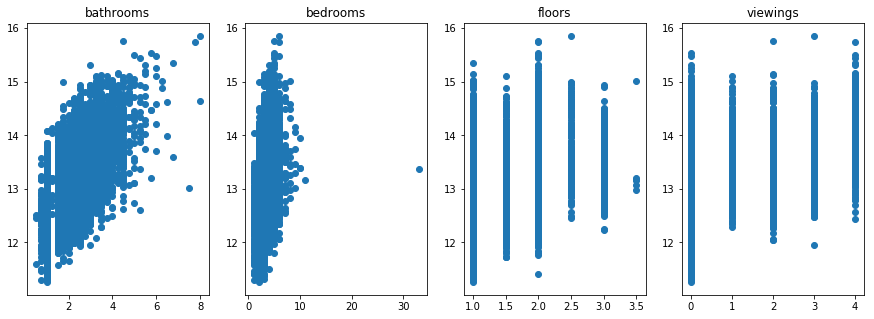

In [161]:
fig = plt.figure(figsize = [15,5])

ax1 = fig.add_subplot(1,4,1)
ax1.scatter(df['bathrooms'],df['pricelog'])
ax1.set_title('bathrooms')

ax2 = fig.add_subplot(1,4,2)
ax2.scatter(df['bedrooms'],df['pricelog'])
ax2.set_title('bedrooms')

ax3 = fig.add_subplot(1,4,3)
ax3.scatter(df['floors'],df['pricelog'])
ax3.set_title('floors')

ax4 = fig.add_subplot(1,4,4)
ax4.scatter(df['view'],df['pricelog'])
ax4.set_title('viewings')

It seems a bit odd that `.corr()` for `grade` and `condition` don't seem to contribute a lot. Let's take a closer look.

Text(0.5, 1.0, 'condition')

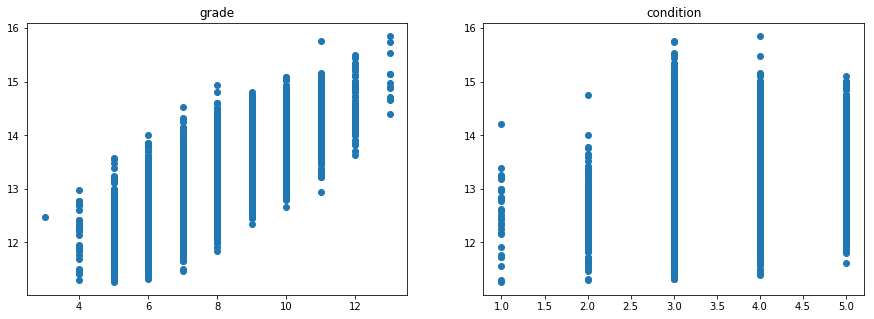

In [164]:
fig = plt.figure(figsize = [15,5])

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df['grade'],df['pricelog'])
ax1.set_title('grade')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df['condition'],df['pricelog'])
ax2.set_title('condition')

Going over some of this `grade` looks useful. `bedrooms` might work out to a stronger fit if we take a look at it a little more closely. 33 bathrooms - this house should be disproportionately large.

In [175]:
df.loc[df['bedrooms']==33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog,sqft_livinglog,grg,grg_dcenter,bathlog
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,98103,47.6878,-122.331,1330,4700,13.369223,7.390181,-5833.696262,18.982925,0.559616


If that's right, given that `sqft_living` is the square footage of the home, then the home must be **mostly bedrooms**, each with only 49sqft of space. I don't think the logistics of all those bedrooms and <2 bathrooms makes sense, do you? This must be a typo. Let's correct it to reflect the median value of bedrooms.

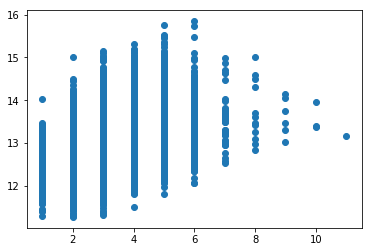

In [179]:
df.loc[df['bedrooms']==33, 'bedrooms'] = df['bedrooms'].median()
plt.scatter(df['bedrooms'],df['pricelog'])

That looks much better. It's correlated, but still very spread out. Let's see if it improved our `.corr()`.

In [180]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,pricelog,sqft_livinglog,grg,grg_dcenter,bathlog
id,1.000000,-0.018183,0.004313,0.003900,-0.013662,-0.132794,0.019030,-0.003792,0.011086,-0.022093,...,-0.007295,-0.004350,0.021011,-0.004051,-0.138706,-0.006103,-0.003201,0.011282,-0.008587,0.012917
price,-0.018183,1.000000,0.317586,0.526757,0.702790,0.088384,0.255378,0.266549,0.393069,0.036172,...,-0.052655,0.305339,0.021363,0.584449,0.082992,0.891452,0.612008,-0.264042,-0.278656,0.456204
bedrooms,0.004313,0.317586,1.000000,0.529022,0.594588,0.034463,0.184414,-0.002162,0.081159,0.021490,...,-0.158214,-0.012947,0.135825,0.405153,0.032460,0.352049,0.638850,0.059365,-0.029327,0.521729
bathrooms,0.003900,0.526757,0.529022,1.000000,0.755893,0.089415,0.503405,0.064271,0.186356,-0.127350,...,-0.204253,0.023447,0.224609,0.569712,0.088926,0.551478,0.762083,0.058253,-0.042207,0.970437
sqft_living,-0.013662,0.702790,0.594588,0.755893,1.000000,0.175048,0.353515,0.105542,0.281639,-0.060849,...,-0.200248,0.051286,0.241386,0.756825,0.185463,0.695856,0.954407,0.039433,-0.093343,0.708016
sqft_lot,-0.132794,0.088384,0.034463,0.089415,0.175048,1.000000,-0.006461,0.021831,0.072508,-0.008690,...,-0.130296,-0.086335,0.231066,0.145821,0.722416,0.099299,0.151749,0.158117,0.101428,0.075893
floors,0.019030,0.255378,0.184414,0.503405,0.353515,-0.006461,1.000000,0.020827,0.027113,-0.264980,...,-0.058612,0.048510,0.125942,0.278872,-0.009957,0.309650,0.367439,0.001153,-0.005884,0.502203
waterfront,-0.003792,0.266549,-0.002162,0.064271,0.105542,0.021831,0.020827,1.000000,0.386162,0.016854,...,0.029433,-0.012347,-0.038160,0.084777,0.030782,0.172735,0.079710,-0.002401,-0.049141,0.047650
view,0.011086,0.393069,0.081159,0.186356,0.281639,0.072508,0.027113,0.386162,1.000000,0.045265,...,0.086199,0.006707,-0.078357,0.278246,0.071907,0.344498,0.244295,-0.033562,-0.062934,0.157326
condition,-0.022093,0.036172,0.021490,-0.127350,-0.060849,-0.008690,-0.264980,0.016854,0.045265,1.000000,...,0.003710,-0.015512,-0.106781,-0.092819,-0.003816,0.038458,-0.051468,-0.023854,0.008837,-0.114554


It improved our `.corr` but only barely. At this point, I think we've seen what we need to move forward with our multiple linear regression.

# Building Out The Model

From here, we're going to use our observations of the data and start plugging values in to see how closely we can predict outcomes.

### How much can we get from single-variable correlation?

To answer this, we'd start with the correlation that was the strongest for our `pricelog`.

In [194]:
model = ols(formula = 'pricelog ~ sqft_living', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 1.976e+04
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:11:06   Log-Likelihood:                -9402.8
No. Observations:               21054   AIC:                         1.881e+04
Df Residuals:                   21052   BIC:                         1.883e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2205      0.006   1895.807      0.000      12.208      12.233
sqft_living     0.0004   2.83e-06    140.583      0.000       0.000       0.000
==============================================================================
Omnibus:                        3.612   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.633
Skew:                           0.029   Prob(JB):                        0.163
Kurtosis:                       2.974   Cond. No.                     5.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### It can't hurt to use geography!

Getting 50% on the first r-squared test is good, but let's see how location impacts it.

Really good results with using loggrg, logprice, sqft_living, grade, and waterfront


In [195]:
model2 = ols(formula = 'pricelog ~ sqft_living + long + lat', data=df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                 1.351e+04
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:12:23   Log-Likelihood:                -5071.1
No. Observations:               21054   AIC:                         1.015e+04
Df Residuals:                   21050   BIC:                         1.018e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -88.8207      1.949    -45.573      0.000     -92.641     -85.001
sqft_living     0.0004   2.38e-06    165.506      0.000       0.000       0.000
long           -0.2286      0.016    -14.556      0.000      -0.259      -0.198
lat             1.5373      0.016     99.053      0.000       1.507       1.568
==============================================================================
Omnibus:                      511.625   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.943
Skew:                           0.093   Prob(JB):                    1.45e-249
Kurtosis:                       4.128   Cond. No.                     2.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

66% is a pretty strong place to be at this point, so from here, we're going to fine tune it with some variables that we'd seen earlier showed some linearity with `pricelog`.

In [202]:
model3 = ols(formula = 'pricelog ~ sqft_living + long + lat + condition + grade', data=df).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                 1.094e+04
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:19:45   Log-Likelihood:                -2892.2
No. Observations:               21054   AIC:                             5796.
Df Residuals:                   21048   BIC:                             5844.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -84.7741      1.763    -48.079      0.000     -88.230     -81.318
sqft_living     0.0002   3.27e-06     71.662      0.000       0.000       0.000
long           -0.2234      0.014    -15.696      0.000      -0.251      -0.196
lat             1.4383      0.014    102.044      0.000       1.411       1.466
condition       0.0959      0.003     32.040      0.000       0.090       0.102
grade           0.1696      0.003     65.929      0.000       0.165       0.175
==============================================================================
Omnibus:                      620.650   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              993.940
Skew:                           0.281   Prob(JB):                    1.47e-216
Kurtosis:                       3.904   Cond. No.                     2.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Let's adjust to include basic housing featres (baths, bedrooms, floors)

In [203]:
model4 = ols(formula = 'pricelog ~ sqft_living + long + lat + condition + grade + bathrooms + bedrooms + floors', data=df).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     6875.
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:19:51   Log-Likelihood:                -2848.4
No. Observations:               21054   AIC:                             5715.
Df Residuals:                   21045   BIC:                             5786.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -85.2487      1.763    -48.350      0.000     -88.705     -81.793
sqft_living     0.0002   4.15e-06     57.924      0.000       0.000       0.000
long           -0.2283      0.014    -16.049      0.000      -0.256      -0.200
lat             1.4368      0.014    102.005      0.000       1.409       1.464
condition       0.1001      0.003     32.605      0.000       0.094       0.106
grade           0.1619      0.003     59.246      0.000       0.157       0.167
bathrooms       0.0193      0.004      4.558      0.000       0.011       0.028
bedrooms       -0.0216      0.003     -7.941      0.000      -0.027      -0.016
floors          0.0103      0.004      2.375      0.018       0.002       0.019
==============================================================================
Omnibus:                      651.331   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1065.066
Skew:                           0.286   Prob(JB):                    5.29e-232
Kurtosis:                       3.942   Cond. No.                     2.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Oh wow, that really hurt is in the end. Even though some of those variables had showng pretty significant correlation values. We'll take them out.

### Let's try some esoteric variables:

Not a lot of properties are going to have waterfront views, but if our model is able to explain 70+% of what it's seeing, `waterfront` might help get the rest. What about `view`?

In [216]:
model4 = ols(formula = 'pricelog ~ sqft_living + long + lat + condition + grade + waterfront + view', data=df).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     8648.
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:23:59   Log-Likelihood:                -2109.3
No. Observations:               21054   AIC:                             4235.
Df Residuals:                   21046   BIC:                             4298.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -75.6297      1.716    -44.065      0.000     -78.994     -72.266
sqft_living     0.0002   3.19e-06     67.217      0.000       0.000       0.000
long           -0.1402      0.014    -10.095      0.000      -0.167      -0.113
lat             1.4617      0.014    107.530      0.000       1.435       1.488
condition       0.0896      0.003     31.007      0.000       0.084       0.095
grade           0.1635      0.002     65.803      0.000       0.159       0.168
waterfront      0.3800      0.024     15.773      0.000       0.333       0.427
view            0.0790      0.003     28.695      0.000       0.074       0.084
==============================================================================
Omnibus:                      401.027   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              710.407
Skew:                           0.150   Prob(JB):                    5.46e-155
Kurtosis:                       3.849   Cond. No.                     2.12e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [221]:
model5 = ols(formula = 'pricelog ~ sqft_living + long + lat + condition + grade + waterfront + view + yr_built', data=df).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     8042.
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:25:57   Log-Likelihood:                -1629.9
No. Observations:               21054   AIC:                             3278.
Df Residuals:                   21045   BIC:                             3349.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -48.8481      1.883    -25.939      0.000     -52.539     -45.157
sqft_living     0.0002   3.12e-06     66.838      0.000       0.000       0.000
long            0.0053      0.014      0.369      0.712      -0.023       0.033
lat             1.3750      0.014    101.303      0.000       1.348       1.402
condition       0.0591      0.003     19.780      0.000       0.053       0.065
grade           0.1921      0.003     74.029      0.000       0.187       0.197
waterfront      0.3815      0.024     16.199      0.000       0.335       0.428
view            0.0679      0.003     25.025      0.000       0.063       0.073
yr_built       -0.0025   8.06e-05    -31.312      0.000      -0.003      -0.002
==============================================================================
Omnibus:                      374.223   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.793
Skew:                           0.014   Prob(JB):                    9.40e-169
Kurtosis:                       3.939   Cond. No.                     3.08e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Adding in `yr_built` got us over 75%, but now the p value for `long` has fallen out of relevance.

In [222]:
model5 = ols(formula = 'pricelog ~ sqft_living + lat + condition + grade + waterfront + view + yr_built', data=df).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     9191.
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        02:27:12   Log-Likelihood:                -1630.0
No. Observations:               21054   AIC:                             3276.
Df Residuals:                   21046   BIC:                             3340.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -49.4947      0.693    -71.453      0.000     -50.852     -48.137
sqft_living     0.0002   3.08e-06     67.927      0.000       0.000       0.000
lat             1.3746      0.014    101.628      0.000       1.348       1.401
condition       0.0592      0.003     19.802      0.000       0.053       0.065
grade           0.1920      0.003     74.239      0.000       0.187       0.197
waterfront      0.3814      0.024     16.196      0.000       0.335       0.428
view            0.0678      0.003     25.097      0.000       0.063       0.073
yr_built       -0.0025   7.63e-05    -32.970      0.000      -0.003      -0.002
==============================================================================
Omnibus:                      373.799   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              772.589
Skew:                           0.014   Prob(JB):                    1.72e-168
Kurtosis:                       3.938   Cond. No.                     1.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks like the model works fine without longitude. This is likely because at this point we have more factors that are playing a stronger role in determination than longitude itself was.